In [1]:
import random
import torch
import tokenizer_basic
import transformer_tiny
from torch.utils.data import DataLoader
import torch.nn as nn
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import numpy as np
import json
import os


In [2]:
tiny_stories=[]
tstxt=[r'D:\SE\AI general\Dataset\TinyStories\TinyStoriesV2-GPT4-train.txt',r'D:\SE\AI general\Dataset\TinyStories\TinyStoriesV2-GPT4-valid.txt']

with open(tstxt[1], 'r', encoding='utf-8') as file:
    # for j in range (100):
    a=file.readline()
    story=""
    while a:
        if a!="<|endoftext|>\n":
            story+=a
        else:
            tiny_stories.append(story)
            story=""
        # print (str(a))
        a=file.readline()

# tiny_stories.sort(key=len)
print (len(tiny_stories))
for j in range (2):
    print (tiny_stories[random.randint(0,len(tiny_stories))])

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\SE\\AI general\\Dataset\\TinyStories\\TinyStoriesV2-GPT4-valid.txt'

In [3]:
# Create and train the tokenizer
tokenizer = tokenizer_basic.HybridTokenizer(vocab_size=3200)

tokenizer.load_vocab("tinystories_tokenizer_vocab.json")
# Build vocabulary from the loaded stories
# tokenizer.build_vocab(tiny_stories)

print(f"\nTokenizer trained successfully!")
print(f"Total vocabulary size: {tokenizer.get_vocab_size()}")
print(f"Word vocabulary: {len(tokenizer.word_to_id)} tokens")
print(f"Character vocabulary: {len(tokenizer.char_to_id)} characters")


Vocabulary loaded from tinystories_tokenizer_vocab.json

Tokenizer trained successfully!
Total vocabulary size: 3266
Word vocabulary: 3206 tokens
Character vocabulary: 60 characters


In [6]:
# Test the tokenizer with sample stories
print("=== TOKENIZER TESTING ===\n")

# Test with a sample story
test_story = tiny_stories[0]  # First 200 chars of first story
print(f"Original text: {test_story}")
print()

# Encode the story
encoded = tokenizer.encode(test_story)
print(f"Encoded IDs: {encoded}")
print(f"Sequence length: {len(encoded)}")
print()

# Decode back to text
decoded = tokenizer.decode(encoded)
print(f"Decoded text: {decoded}")
print()

# Test with a sentence containing rare words
test_rare = "The xylophone played melodious symphonies while extraordinary creatures danced."
print(f"Test with rare words: {test_rare}")
encoded_rare = tokenizer.encode(test_rare)
print(f"Encoded: {encoded_rare}")
decoded_rare = tokenizer.decode(encoded_rare)
print(f"Decoded: {decoded_rare}")
print()

# Show some examples of word vs character encoding
print("=== WORD vs CHARACTER ENCODING EXAMPLES ===")
test_words = ["the", "and", "was", "xylophone", "extraordinary", "symphonies"]
for word in test_words:
    encoded_word = tokenizer.encode_word_or_chars(word)
    is_word_level = len(encoded_word) == 1 and encoded_word[0] < len(tokenizer.word_to_id)
    encoding_type = "WORD" if is_word_level else "CHAR"
    print(f"'{word}' -> {encoded_word} ({encoding_type})")

print()

# Test batch encoding for PyTorch
print("=== PYTORCH BATCH ENCODING ===")
test_batch = [
    "Once upon a time, there was a little girl.",
    "She loved to play with her toys.",
    "The end."
]

batch_encoded = tokenizer.encode_batch(test_batch, max_length=20, padding=True)
print(f"Batch input_ids shape: {batch_encoded['input_ids'].shape}")
print(f"Batch attention_mask shape: {batch_encoded['attention_mask'].shape}")
print(f"First sequence: {batch_encoded['input_ids'][0].tolist()}")
print(f"First attention mask: {batch_encoded['attention_mask'][0].tolist()}")

# Show vocabulary statistics
print(f"\n=== VOCABULARY STATISTICS ===")
print(f"Most frequent words (top 10):")
word_items = [(word, idx) for word, idx in tokenizer.word_to_id.items() 
              if word not in tokenizer.special_tokens]
word_items_sorted = sorted(word_items, key=lambda x: x[1])[:10]
for word, idx in word_items_sorted:
    print(f"  {idx}: '{word}'")

print(f"\nSpecial tokens:")
for token, idx in tokenizer.special_tokens.items():
    print(f"  {idx}: {token}")

print(f"\nCharacter vocabulary (first 20):")
char_items = sorted(tokenizer.char_to_id.items(), key=lambda x: x[1])[:20]
for char, idx in char_items:
    display_char = repr(char) if char in ['\n', '\t', ' '] else char
    print(f"  {idx + len(tokenizer.word_to_id)}: {display_char}")


=== TOKENIZER TESTING ===

Original text: u don't have to be scared of the loud dog, I'll protect you". The mole felt so safe with the little girl. She was very kind and the mole soon came to trust her. He leaned against her and she kept him safe. The mole had found his best friend.


Encoded IDs: [2, 4, 3248, 5, 182, 24, 76, 86, 11, 66, 134, 38, 7, 280, 67, 8, 34, 24, 822, 1202, 27, 12, 6, 7, 1579, 105, 45, 241, 19, 7, 44, 70, 6, 17, 13, 39, 215, 9, 7, 1579, 238, 108, 11, 1386, 23, 6, 15, 2326, 2079, 23, 9, 17, 344, 75, 241, 6, 7, 1579, 31, 88, 22, 167, 93, 6, 3]
Sequence length: 65

Decoded text: u don ' t have to be scared of the loud dog , i ' ll protect you " . the mole felt so safe with the little girl . she was very kind and the mole soon came to trust her . he leaned against her and she kept him safe . the mole had found his best friend .

Test with rare words: The xylophone played melodious symphonies while extraordinary creatures danced.
Encoded: [2, 7, 4, 3251, 3252, 3239, 3

In [7]:
# Save the tokenizer vocabulary
tokenizer.save_vocab("tinystories_tokenizer_vocab.json")

Vocabulary saved to tinystories_tokenizer_vocab.json


In [6]:


# Example: Create a PyTorch Dataset class for training
class TinyStoriesDataset(torch.utils.data.Dataset):
    def __init__(self, stories, tokenizer, max_length=512):
        self.stories = stories
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.stories)
    
    def __getitem__(self, idx):
        story = self.stories[idx]
        
        # Encode the story
        encoded = self.tokenizer.encode(story, add_special_tokens=True)
        
        # Truncate if too long
        if len(encoded) > self.max_length:
            encoded = encoded[:self.max_length]
        
        # For language modeling, input is sequence[:-1] and target is sequence[1:]
        input_ids = encoded[:-1] if len(encoded) > 1 else [self.tokenizer.pad_id]
        labels = encoded[1:] if len(encoded) > 1 else [self.tokenizer.pad_id]
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.long)
        }

# Create dataset
dataset = TinyStoriesDataset(tiny_stories, tokenizer, max_length=512)  # First 1000 stories
print(f"Dataset created with {len(dataset)} stories")
# print(dataset[0])

# Test dataset
sample = dataset[0]
print(f"Sample input_ids shape: {sample['input_ids'].shape}")
print(f"Sample labels shape: {sample['labels'].shape}")



def collate_fn(batch):
    # Pad sequences in batch
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['labels'] for item in batch]
    
    # Pad to max length in batch
    max_len = max(len(seq) for seq in input_ids)
    
    padded_inputs = []
    padded_labels = []
    attention_masks = []
    
    for i in range(len(input_ids)):
        seq_len = len(input_ids[i])
        
        # Pad input_ids
        padded_input = torch.cat([
            input_ids[i],
            torch.full((max_len - seq_len,), tokenizer.pad_id, dtype=torch.long)
        ])
        
        # Pad labels  
        padded_label = torch.cat([
            labels[i],
            torch.full((max_len - seq_len,), -100, dtype=torch.long)  # -100 is ignored in loss
        ])
        
        # Create attention mask
        attention_mask = torch.cat([
            torch.ones(seq_len, dtype=torch.long),
            torch.zeros(max_len - seq_len, dtype=torch.long)
        ])
        
        padded_inputs.append(padded_input)
        padded_labels.append(padded_label)
        attention_masks.append(attention_mask)
    
    return {
        'input_ids': torch.stack(padded_inputs),
        'labels': torch.stack(padded_labels),
        'attention_mask': torch.stack(attention_masks)
    }

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

# Test batch
batch = next(iter(dataloader))
print(f"\nBatch shapes:")
print(f"input_ids: {batch['input_ids'].shape}")
print(f"labels: {batch['labels'].shape}")
print(f"attention_mask: {batch['attention_mask'].shape}")

print(f"\n=== TOKENIZER READY FOR TRAINING ===")
print(f"Vocabulary size: {tokenizer.get_vocab_size()}")
print(f"Word-level tokens: {len(tokenizer.word_to_id)}")
print(f"Character-level tokens: {len(tokenizer.char_to_id)}")
print(f"Dataset ready with {len(dataset)} samples")
print(f"DataLoader ready with batch size 4")

# Example of loading the tokenizer later
print(f"\n=== EXAMPLE: LOADING SAVED TOKENIZER ===")
new_tokenizer = tokenizer_basic.HybridTokenizer()
new_tokenizer.load_vocab("tinystories_tokenizer_vocab.json")
print(f"Loaded tokenizer with vocab size: {new_tokenizer.get_vocab_size()}")


Dataset created with 27630 stories
Sample input_ids shape: torch.Size([64])
Sample labels shape: torch.Size([64])

Batch shapes:
input_ids: torch.Size([32, 490])
labels: torch.Size([32, 490])
attention_mask: torch.Size([32, 490])

=== TOKENIZER READY FOR TRAINING ===
Vocabulary size: 3266
Word-level tokens: 3206
Character-level tokens: 60
Dataset ready with 27630 samples
DataLoader ready with batch size 4

=== EXAMPLE: LOADING SAVED TOKENIZER ===
Vocabulary loaded from tinystories_tokenizer_vocab.json
Loaded tokenizer with vocab size: 3266


In [4]:
tiny_transformer=transformer_tiny.TinyTransformer(
    vocab_size=tokenizer.get_vocab_size(),
    n_embd=192,
    n_head=6,
    n_layer=6,
    max_context=512,
    dropout=0.1
)
print(tiny_transformer)
total_params = sum(p.numel() for p in tiny_transformer.parameters())
print(f"Total parameters: {total_params:,}")


TinyTransformer(
  (token_embedding): Embedding(3266, 192)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0-5): 6 x Block(
      (sa): MultiHeadAttention(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (key): Linear(in_features=192, out_features=32, bias=False)
            (query): Linear(in_features=192, out_features=32, bias=False)
            (value): Linear(in_features=192, out_features=32, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (proj): Linear(in_features=192, out_features=192, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=192, out_features=768, bias=False)
          (1): GELU(approximate='none')
          (2): Linear(in_features=768, out_features=192, bias=False)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (ln1): LayerNorm((192,), eps=1e-05, eleme

In [20]:
torch.load("final_model.pth")
tiny_transformer.load_state_dict(torch.load("final_model.pth")['model_state_dict'])

<All keys matched successfully>

In [ ]:
# Training configuration
num_epochs = 3
learning_rate = 3e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
tiny_transformer = tiny_transformer.to(device)

# Setup optimizer and loss function
optimizer = torch.optim.AdamW(tiny_transformer.parameters(), lr=learning_rate, weight_decay=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # -100 tokens are ignored

# Training statistics
train_losses = []
best_loss = float('inf')

print(f"Starting training for {num_epochs} epochs...")
print(f"Total batches per epoch: {len(dataloader)}")
print(f"Learning rate: {learning_rate}")
print("-" * 50)

# Training loop
for epoch in range(num_epochs):
    tiny_transformer.train()
    epoch_losses = []
    epoch_start_time = time.time()
    
    # Progress bar for the epoch
    pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}', 
                leave=True, dynamic_ncols=True)
    
    for batch_idx, batch in enumerate(pbar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        # Forward pass
        optimizer.zero_grad()
        
        # Get model outputs (logits)
        outputs = tiny_transformer(input_ids)  # Shape: [batch_size, seq_len, vocab_size]
        
        # Reshape for loss calculation
        # outputs: [batch_size * seq_len, vocab_size]
        # labels: [batch_size * seq_len]
        loss = criterion(outputs.reshape(-1, outputs.size(-1)), labels.reshape(-1))
        
        # Backward pass and optimization
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(tiny_transformer.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # Track loss
        current_loss = loss.item()
        epoch_losses.append(current_loss)
        train_losses.append(current_loss)
        
        # Update progress bar
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        pbar.set_postfix({
            'Loss': f'{current_loss:.4f}',
            'Avg Loss': f'{avg_loss:.4f}',
            'LR': f'{learning_rate:.2e}'
        })
        
        # Removed frequent batch logging to keep progress bar clean
        # All relevant info (Loss, Avg Loss, LR) is shown in the progress bar
    
    # End of epoch statistics
    epoch_time = time.time() - epoch_start_time
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    
    print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
    print(f"  Average Loss: {avg_epoch_loss:.4f}")
    print(f"  Time: {epoch_time:.2f}s")
    print(f"  Batches processed: {len(epoch_losses)}")
    
    # Save best model
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': tiny_transformer.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
            'vocab_size': tokenizer.get_vocab_size(),
        }, 'best_model.pth')
        print(f"  ✓ New best model saved! Loss: {best_loss:.4f}")
    
    print("-" * 50)

print(f"\n🎉 Training completed!")
print(f"Final average loss: {train_losses[-1]:.4f}")
print(f"Best loss achieved: {best_loss:.4f}")
print(f"Total training samples processed: {len(train_losses)}")

# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': tiny_transformer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'vocab_size': tokenizer.get_vocab_size(),
    'train_losses': train_losses,
}, 'final_model2.pth')
print("Final model saved as 'final_model.pth'")


Using device: cuda
Starting training for 3 epochs...
Total batches per epoch: 864
Learning rate: 0.0003
--------------------------------------------------


Epoch 1/3: 100%|██████████| 864/864 [05:32<00:00,  2.60it/s, Loss=3.4320, Avg Loss=4.3443, LR=3.00e-04]



Epoch 1/3 Summary:
  Average Loss: 4.3443
  Time: 332.13s
  Batches processed: 864
  ✓ New best model saved! Loss: 4.3443
--------------------------------------------------


Epoch 2/3: 100%|██████████| 864/864 [08:33<00:00,  1.68it/s, Loss=2.9764, Avg Loss=3.2588, LR=3.00e-04]



Epoch 2/3 Summary:
  Average Loss: 3.2588
  Time: 513.34s
  Batches processed: 864
  ✓ New best model saved! Loss: 3.2588
--------------------------------------------------


Epoch 3/3: 100%|██████████| 864/864 [05:56<00:00,  2.43it/s, Loss=2.8641, Avg Loss=2.9037, LR=3.00e-04]



Epoch 3/3 Summary:
  Average Loss: 2.9037
  Time: 356.28s
  Batches processed: 864
  ✓ New best model saved! Loss: 2.9037
--------------------------------------------------

🎉 Training completed!
Final average loss: 2.8641
Best loss achieved: 2.9037
Total training samples processed: 2592
Final model saved as 'final_model.pth'


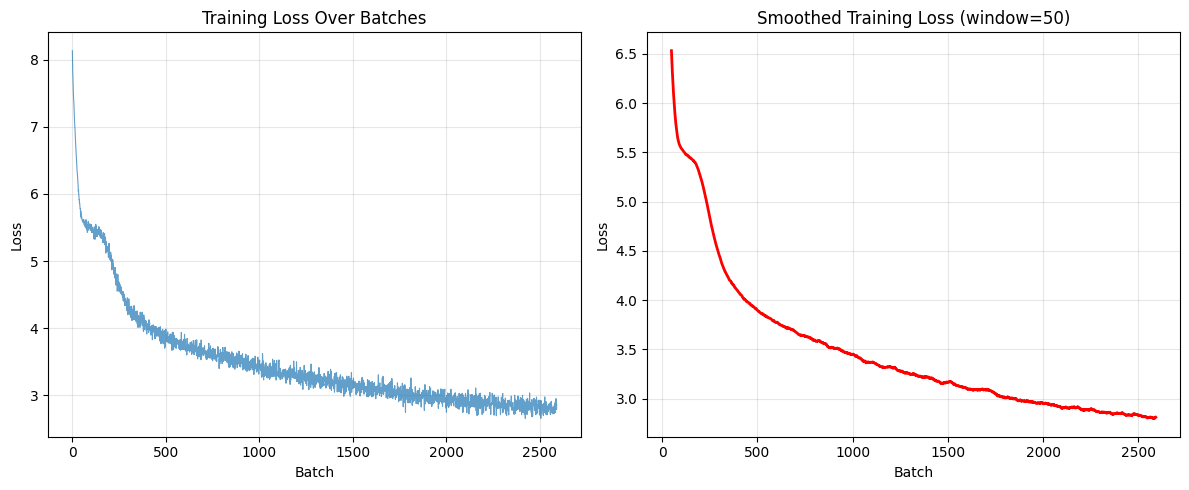

Training statistics:
  Initial loss: 8.1318
  Final loss: 2.8641
  Best loss: 2.9037
  Loss improvement: 5.2677
  Relative improvement: 64.78%


In [9]:

if len(train_losses) > 0:
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Raw loss over batches
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, alpha=0.7, linewidth=0.8)
    plt.title('Training Loss Over Batches')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Smoothed loss (moving average)
    plt.subplot(1, 2, 2)
    window_size = min(50, len(train_losses) // 10)  # Adaptive window size
    if window_size > 1:
        smoothed_loss = np.convolve(train_losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(train_losses)), smoothed_loss, color='red', linewidth=2)
        plt.title(f'Smoothed Training Loss (window={window_size})')
    else:
        plt.plot(train_losses, color='red', linewidth=2)
        plt.title('Training Loss')
    
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_progress.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Training statistics:")
    print(f"  Initial loss: {train_losses[0]:.4f}")
    print(f"  Final loss: {train_losses[-1]:.4f}")
    print(f"  Best loss: {best_loss:.4f}")
    print(f"  Loss improvement: {train_losses[0] - train_losses[-1]:.4f}")
    print(f"  Relative improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
else:
    print("No training losses to plot. Run the training cell first.")


In [16]:
prompt = "this morning i walk"
max_token = 128

# Set model to evaluation mode
tiny_transformer.eval()

# Encode the prompt
prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)
print(f"Prompt: '{prompt}'")
print(f"Encoded prompt: {prompt_ids}")

# Convert to tensor and add batch dimension
input_ids = torch.tensor(prompt_ids, dtype=torch.long).unsqueeze(0)  # Shape: [1, seq_len]

# Move to device if using GPU
device = next(tiny_transformer.parameters()).device
input_ids = input_ids.to(device)

print(f"Generating {max_token} new tokens...")
print("="*50)

# Generation parameters
temperature = 0.0
top_k = 50

# Keep track of generated tokens
generated_tokens = []
current_sequence = input_ids.clone()

print("Streaming generation:")
print(f"Starting with: '{tokenizer.decode(current_sequence[0].tolist())}'")
print("\nGenerated tokens:")

# Generate tokens one by one
with torch.no_grad():
    for step in range(max_token):
        # Crop sequence to max context if needed
        if current_sequence.size(1) > tiny_transformer.max_context:
            current_sequence = current_sequence[:, -tiny_transformer.max_context:]
        
        # Forward pass to get logits
        logits = tiny_transformer(current_sequence)  # Shape: [1, seq_len, vocab_size]
        
        # Get logits for the last position (next token prediction)
        next_token_logits = logits[:, -1, :]  # Shape: [1, vocab_size]
        
        # Handle different sampling strategies
        if temperature == 0.0:
            # Greedy decoding: choose token with highest logit
            next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)  # Shape: [1, 1]
        else:
            # Temperature sampling
            next_token_logits = next_token_logits / temperature
            
            # Apply top-k filtering
            if top_k is not None:
                v, _ = torch.topk(next_token_logits, min(top_k, next_token_logits.size(-1)))
                next_token_logits[next_token_logits < v[:, [-1]]] = -float('inf')
            
            # Convert logits to probabilities
            probs = torch.softmax(next_token_logits, dim=-1)
            
            # Sample next token
            next_token = torch.multinomial(probs, num_samples=1)  # Shape: [1, 1]
        
        # Add to sequence
        current_sequence = torch.cat([current_sequence, next_token], dim=1)
        
        # Store the generated token
        token_id = next_token[0, 0].item()
        generated_tokens.append(token_id)
        
        # Decode and print the new token
        try:
            # Try to decode just this token
            if token_id in tokenizer.id_to_word:
                token_text = tokenizer.id_to_word[token_id]
            else:
                # For character-level tokens, decode in context
                token_text = tokenizer.decode([token_id])
            
            print(f"Step {step+1:3d}: Token ID {token_id:4d} -> '{token_text}'")
            
            # Check for end of sequence
            if token_id == tokenizer.eos_id:
                print("End of sequence token generated!")
                break
                
        except Exception as e:
            print(f"Step {step+1:3d}: Token ID {token_id:4d} -> [decode error: {e}]")

print("\n" + "="*50)
print("Generation complete!")

# Decode the full generated sequence
full_sequence = current_sequence[0].tolist()
full_text = tokenizer.decode(full_sequence)
print(f"Full generated text: '{full_text}'")

# Show just the new part
original_length = len(prompt_ids)
new_tokens_text = tokenizer.decode(generated_tokens)
print(f"Original prompt: '{prompt}'")
print(f"Generated continuation: '{new_tokens_text}'")
print(f"Total tokens generated: {len(generated_tokens)}")


Prompt: 'this morning i walk'
Encoded prompt: [2, 139, 730, 34, 284, 3]
Generating 128 new tokens...
Streaming generation:
Starting with: 'this morning i walk'

Generated tokens:
Step   1: Token ID    6 -> '.'
Step   2: Token ID   16 -> 'it'
Step   3: Token ID   13 -> 'was'
Step   4: Token ID   10 -> 'a'
Step   5: Token ID   28 -> 'big'
Step   6: Token ID    8 -> ','
Step   7: Token ID  594 -> 'round'
Step   8: Token ID  200 -> 'sun'
Step   9: Token ID    6 -> '.'
Step  10: Token ID   16 -> 'it'
Step  11: Token ID   13 -> 'was'
Step  12: Token ID   10 -> 'a'
Step  13: Token ID   28 -> 'big'
Step  14: Token ID    8 -> ','
Step  15: Token ID  161 -> 'red'
Step  16: Token ID   77 -> 'ball'
Step  17: Token ID    6 -> '.'
Step  18: Token ID   16 -> 'it'
Step  19: Token ID   13 -> 'was'
Step  20: Token ID   10 -> 'a'
Step  21: Token ID   28 -> 'big'
Step  22: Token ID    8 -> ','
Step  23: Token ID  161 -> 'red'
Step  24: Token ID   77 -> 'ball'
Step  25: Token ID    6 -> '.'
Step  26: Token

In [26]:


export_dir = '../model/weights'
os.makedirs(export_dir, exist_ok=True)
state_dict = tiny_transformer.state_dict()

with open(os.path.join(export_dir, 'metadata.txt'), 'w') as f:
    for name, tensor in state_dict.items():
        np_array = tensor.detach().cpu().numpy().astype(np.float32)
        # print (np_array[0][:10])
        bin_path = os.path.join(export_dir, name.replace('.', '_') + '.bin')
        np_array.tofile(bin_path)
        
        shape_str = ' '.join(map(str, tensor.shape))
        f.write(f"{name} {shape_str} float32 {np_array.size}\n")

print(f"Weights exported to '{export_dir}' with metadata.txt for pure C++ loading")

Weights exported to '../model/weights' with metadata.txt for pure C++ loading


# Model Compute Debugging

In [ ]:
# Hook System for tiny_transformer - exactly like the example
prompt = "this morning i walk"

# Set model to evaluation mode
tiny_transformer.eval()

# Encode the prompt
prompt_ids = tokenizer.encode(prompt, add_special_tokens=True)

# Convert to tensor and add batch dimension
input_ids = torch.tensor(prompt_ids, dtype=torch.long).unsqueeze(0)  # Shape: [1, seq_len]

# Move to device if using GPU
device = next(tiny_transformer.parameters()).device
input_ids = input_ids.to(device)

# Define a dictionary to store the outputs
activations = {}

# Define a hook function
def get_hook(name):
    def hook_fn(module, input, output):
        activations[name] = output
    return hook_fn

# Register hooks for all layers
hooks = []
for name, layer in tiny_transformer.named_modules():
    hooks.append(layer.register_forward_hook(get_hook(name)))

print(f"Registered {len(hooks)} hooks on all layers")
print(f"Input shape: {input_ids.shape}")

# Run the forward pass
tiny_transformer.eval()
with torch.no_grad():
    out = tiny_transformer(input_ids)

print(f"Model output shape: {out.shape}")
print(f"Model output sum: {torch.sum(out)}")

print("\n" + "="*80)
print("LAYER ACTIVATIONS ANALYSIS")
print("="*80)

# Access the stored outputs
for name, activation in activations.items():
    try:
        if isinstance(activation, torch.Tensor):
            print(f"Layer: {name:40s} | Shape: {str(activation.shape):20s} | Sum: {torch.sum(activation.to(dtype=torch.float64)):15.10f} | Norm: {torch.norm(activation.to(dtype=torch.float64)):15.10f}")
        else:
            print(f"Layer: {name:40s} | Type: {type(activation).__name__:20s} | Content: {str(activation)[:50]}")
    except Exception as e:
        print(f"Layer: {name:40s} | Error: {str(e)[:50]}")

print("\n" + "="*80)
print(f"Total layers with activations captured: {len([a for a in activations.values() if isinstance(a, torch.Tensor)])}")
print("="*80)

# Remove the hooks
for hook in hooks:
    hook.remove()
    
print(f"All {len(hooks)} hooks removed successfully!")


Registered 264 hooks on all layers
Input shape: torch.Size([1, 6])
Model output shape: torch.Size([1, 6, 3266])
Model output sum: -39812.984375

LAYER ACTIVATIONS ANALYSIS
Layer: token_embedding                          | Shape: torch.Size([1, 6, 192]) | Sum:   -9.0557632666 | Norm:    3.9818859744
Layer: dropout                                  | Shape: torch.Size([1, 6, 192]) | Sum:  569.9843522815 | Norm:   24.1955088912
Layer: blocks.0.ln1                             | Shape: torch.Size([1, 6, 192]) | Sum:   -5.1508137006 | Norm:   32.4332542581
Layer: blocks.0.sa.heads.0.key                  | Shape: torch.Size([1, 6, 32]) | Sum:   15.2897159308 | Norm:   15.3424885267
Layer: blocks.0.sa.heads.0.query                | Shape: torch.Size([1, 6, 32]) | Sum:    8.0905164976 | Norm:    8.9466653851
Layer: blocks.0.sa.heads.0.value                | Shape: torch.Size([1, 6, 32]) | Sum:   -3.4559992458 | Norm:    2.9005384412
Layer: blocks.0.sa.heads.0.dropout              | Shape: torch.

In [1]:
for name, param in tiny_transformer.named_parameters():
    print(f"{name}: {param.data[0,:10]}")


NameError: name 'tiny_transformer' is not defined